In [1]:
# Code reference: https://github.com/dennybritz/reinforcement-learning/tree/master/TD and https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/tree/master
import numpy as np
# import gymnasium as gym
import gym
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import copy

In [2]:
env = gym.make('CliffWalking-v0')
env.seed(0)
print("==============Action Space================")
print("Action space:", env.action_space)
print("Sample action:", env.action_space.sample())
print("There are ", env.action_space.n, " possible actions\n")

print("==============Observation Space================")
print("Observation space:", env.observation_space)
print("Sample observation:", env.observation_space.sample())
print("There are ", env.observation_space.n, " possible observations")

# NOTE: current state is calculated by (current_row * nrows + current_col)

==============Action Space================
Action space: Discrete(4)
Sample action: 0
There are  4  possible actions

==============Observation Space================
Observation space: Discrete(48)
Sample observation: 24
There are  48  possible observations


/Users/keithwang/miniforge3_arm64/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/keithwang/miniforge3_arm64/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/keithwang/miniforge3_arm64/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:
env.reset()
print("We first try to take a up step at the initial position.")
ret = env.step(0)
print("Return of env.step(0):", ret)
print()
print("Observation:", ret[0])
print("Reward:", ret[1])
print("Done?:", ret[2])
# print("Truncated?:", ret[3])
print("Info (transition probability):", ret[3])

We first try to take a up step at the initial position.
Return of env.step(0): (24, -1, False, {'prob': 1.0})

Observation: 24
Reward: -1
Done?: False
Info (transition probability): {'prob': 1.0}


/Users/keithwang/miniforge3_arm64/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [4]:
class CliffWalkingAgent:
    def __init__(self, env, num_episodes=500, epsilon=0.1, alpha=0.6, discount_factor=1.0, n_epi_eval=10, eval_every=5, seed=0):
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount_factor = discount_factor
        self.n_epi_eval = n_epi_eval
        self.eval_every = eval_every

        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))

        self.t_step = 0

    def _reset(self):
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))

    def epsilon_greedy_policy(self, state):
        if random.random() > self.epsilon:
            q_best = np.max(self.q_table[state])
            return np.random.choice(np.where(self.q_table[state] == q_best)[0])
        else:
            return env.action_space.sample()

    def q_learning(self, tbar=True):
        """
        Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
        while following an epsilon-greedy policy
        Returns:
            A tuple (Q, (episode_lengths, episode_rewards)).
            Q is the optimal action-value function, a dictionary mapping state -> action values.
            stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
        """

        episode_lengths = np.zeros(self.num_episodes)
        episode_rewards = np.zeros(self.num_episodes)
        episode_rewards_eval = np.zeros(self.num_episodes // self.eval_every)

        if tbar:
            range_bar = tqdm(range(self.num_episodes))
        else:
            range_bar = range(self.num_episodes)

        for i_episode in range_bar:
            # state = env.reset()[0]                        # version 0.26.2
            state = env.reset()                           # version 0.25.2
            for t in itertools.count():
                action = self.epsilon_greedy_policy(state)
                # next_state, reward, done, _, _ = env.step(action)       # version 0.26.2
                next_state, reward, done, _ = env.step(action)            # version 0.25.2
                episode_rewards[i_episode] += reward
                episode_lengths[i_episode] = t
                self.q_table[state][action] += self.alpha * (reward + self.discount_factor * np.max(self.q_table[next_state]) - self.q_table[state][action])
                if done:
                    break
                state = next_state
            if i_episode % self.eval_every == 0:
                episode_rewards_eval[i_episode // self.eval_every] = self.eval_sarsa()


        return episode_lengths, episode_rewards, episode_rewards_eval

    def sarsa(self, tbar=True):
        """
        SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
        Returns:
            A tuple (Q, (episode_lengths, episode_rewards)).
            Q is the optimal action-value function, a dictionary mapping state -> action values.
            stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
        """

        episode_lengths, episode_rewards = np.zeros(self.num_episodes), np.zeros(self.num_episodes)
        episode_rewards_eval = np.zeros(self.num_episodes // self.eval_every)

        if tbar:
            range_bar = tqdm(range(self.num_episodes))
        else:
            range_bar = range(self.num_episodes)

        for i_episode in range_bar:
            # state = env.reset()[0]              # version 0.26.2
            state = env.reset()                 # version 0.25.2
            action = self.epsilon_greedy_policy(state)
            for t in itertools.count():
                # next_state, reward, done, _, _ = env.step(action)           # version 0.26.2
                next_state, reward, done, _ = env.step(action)                # version 0.25.2
                episode_rewards[i_episode] += reward
                episode_lengths[i_episode] = t
                next_action = self.epsilon_greedy_policy(next_state)
                self.q_table[state][action] += self.alpha * (reward + self.discount_factor * self.q_table[next_state][next_action] - self.q_table[state][action])
                if done:
                    break
                state = next_state
                action = next_action
            if i_episode % self.eval_every == 0:
                episode_rewards_eval[i_episode // self.eval_every] = self.eval_sarsa()

        return episode_lengths, episode_rewards, episode_rewards_eval

    def show_optimal_policy(self):
        optimal_policy = []
        for i in range(0, 4):
            optimal_policy.append([])
            for j in range(0, 12):
                if i * 12 + j == 47:
                    optimal_policy[-1].append('E')
                    continue
                best_action = np.argmax(self.q_table[i * 12 + j, :])
                if best_action == 0:
                    optimal_policy[-1].append('U')
                elif best_action == 2:
                    optimal_policy[-1].append('D')
                elif best_action == 3:
                    optimal_policy[-1].append('L')
                elif best_action == 1:
                    optimal_policy[-1].append('R')
        for row in optimal_policy:
            print(row)

    def multi_run_experiment(self, n_runs, algo: str=None):
        if algo not in ["q_learning", "sarsa", "DQN", "DQN_greedy"]:
            raise ValueError("Algo must be 'q_learning' or 'sarsa' or 'DQN' or 'DQN_greedy'")
        self._reset()
        episode_rewards_avg, episode_lengths_avg, episode_eval_rewards_avg = np.zeros(self.num_episodes), np.zeros(self.num_episodes), np.zeros(self.num_episodes // self.eval_every)

        for r in tqdm(range(n_runs)):
            if algo in ["q_learning", "sarsa"]:
                episode_lengths, episode_rewards, episode_eval_rewards = self.q_learning(tbar=False) if algo == "q_learning" else self.sarsa(tbar=False)
            else:
                episode_lengths, episode_rewards, episode_eval_rewards = self.DQN(tbar=False) if algo == "DQN" else self.DQN(tbar=False, greedy=True)
            episode_rewards_avg += episode_rewards
            episode_lengths_avg += episode_lengths
            episode_eval_rewards_avg += episode_eval_rewards
            self._reset()

        episode_rewards_avg /= n_runs
        episode_lengths_avg /= n_runs
        episode_eval_rewards_avg /= n_runs

        return episode_rewards_avg, episode_lengths_avg, episode_eval_rewards_avg
    
    def greedy_policy(self, state):
        q_best = np.max(self.q_table[state])
        return np.random.choice(np.where(self.q_table[state] == q_best)[0])
    
    def eval_sarsa(self): # Q1.1> evaluate the learned policy by SARSA
        episode_rewards = np.zeros(self.n_epi_eval)
        for i_episode in range(self.n_epi_eval):
            # state = env.reset()[0]          # version 0.26.2
            state = env.reset()             # version 0.25.2
            action = self.greedy_policy(state)
            for t in itertools.count():
                # next_state, reward, done, _, _ = env.step(action)       # version 0.26.2
                next_state, reward, done, _ = env.step(action)            # version 0.25.2
                episode_rewards[i_episode] += reward
                next_action = self.greedy_policy(next_state)
                if done or t > 100:
                    break
                state = next_state
                action = next_action

        return np.mean(episode_rewards)

In [5]:
# Final optimal policy
print("Optimal policy learnt using Q-learning and SARSA:\n")
print("\n=====Q-learning======")
agent = CliffWalkingAgent(env)
q_learning_episode_lengths, q_learning_episode_rewards, q_learning_episode_eval_rewards = agent.q_learning()
agent.show_optimal_policy()

print("\n=====SARSA======")
agent._reset()
sarsa_episode_lengths, sarsa_episode_rewards, sarsa_episode_eval_rewards = agent.sarsa()
agent.show_optimal_policy()

Optimal policy learnt using Q-learning and SARSA:


=====Q-learning======


  0%|          | 0/500 [00:00<?, ?it/s]

['L', 'R', 'R', 'R', 'L', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['D', 'R', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'E']

=====SARSA======


  0%|          | 0/500 [00:00<?, ?it/s]

['L', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'R', 'R', 'D', 'D']
['R', 'U', 'U', 'U', 'R', 'U', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'L', 'L', 'U', 'U', 'R', 'U', 'U', 'U', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'E']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

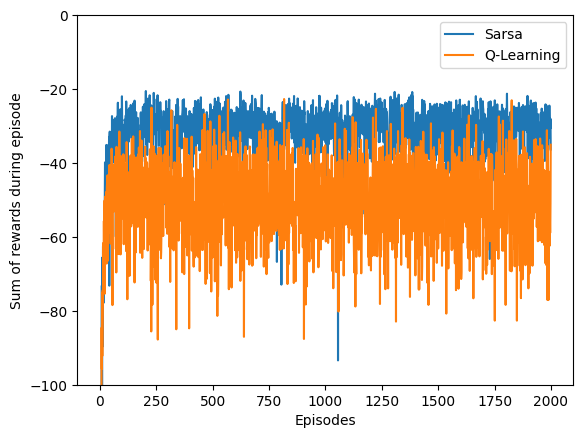

In [6]:
# Comparison between Q leanring and SARSA (Figure in Example 6.6)

n_episodes = 2000
n_runs = 50

agent = CliffWalkingAgent(env, num_episodes=n_episodes)

q_learning_episode_rewards_avg, q_learning_episode_lengths_avg, q_learning_episode_eval_rewards_avg = agent.multi_run_experiment(n_runs, algo="q_learning")
sarsa_episode_rewards_avg, sarsa_episode_lengths_avg, sarsa_episode_eval_rewards_avg = agent.multi_run_experiment(n_runs, algo="sarsa")

plt.plot(sarsa_episode_rewards_avg, label='Sarsa')
plt.plot(q_learning_episode_rewards_avg, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.ylim([-100, 0])
plt.legend()

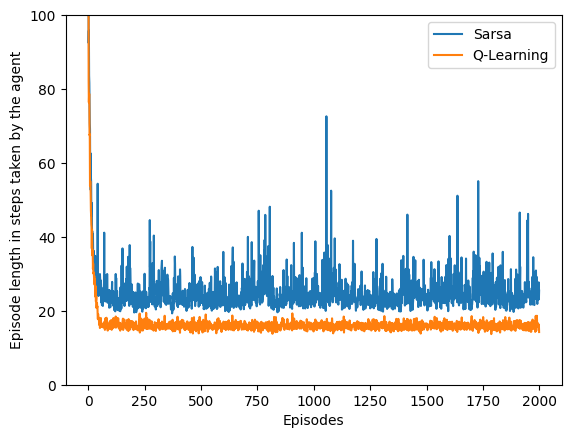

In [7]:
# episode length

plt.plot(sarsa_episode_lengths_avg, label='Sarsa')
plt.plot(q_learning_episode_lengths_avg, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Episode length in steps taken by the agent')
plt.ylim([0, 100])
plt.legend()


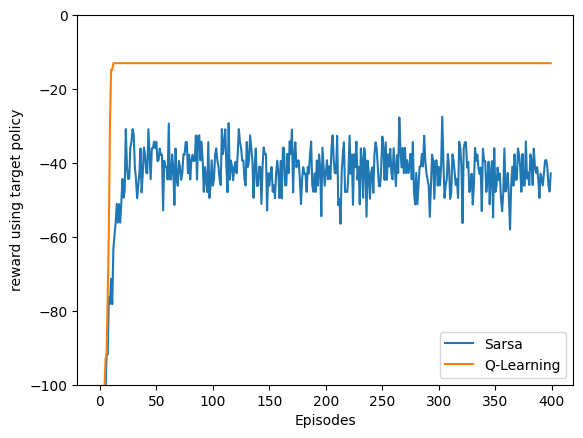

In [8]:
plt.plot(sarsa_episode_eval_rewards_avg, label='Sarsa')
plt.plot(q_learning_episode_eval_rewards_avg, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('reward using target policy')
plt.ylim([-100, 0])
plt.legend()